## Imports

In [102]:
import torch
import torch.nn as nn
import scipy.stats as stats
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import optim
import matplotlib.pyplot as plt

In [45]:
from icnnet import ICNNet
from mydataset import MyDataset
import toy_data_dataloader_gaussian

In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Toy data


In [47]:
dataloader, locs, scales = toy_data_dataloader_gaussian.get_dataloader(N = 500, batch_size = 100, r = 200)

## Training

### PICNN training

In [48]:
epochs = 100

# Initialize the model
model = ICNNet(input_size=2, layer_sizes = [2,8,32,64,32,8,2], context_layer_sizes=[2,8,8,8,8,8,2])
model.train()

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

for epoch in range(epochs):
    for x_batch, c_batch, y_batch in dataloader:
        x_batch.requires_grad_(True)
        c_batch.requires_grad_(True)

        optimizer.zero_grad() # Zero the gradients
        
        output = model(x_batch, c_batch)  # Assuming context c is same as input x

        loss = criterion(output, y_batch) # Compute the loss
        loss.backward() # Backward pass

        optimizer.step() # Update the parameters
        for layers_k in model.layers_z:
            for param in layers_k.parameters():
                param.data.clamp_min_(0)

    # for name, parameter in model.named_parameters():
    #     if parameter.requires_grad and parameter.grad is not None:
    #         grad_norm = parameter.grad.norm().item()
    #         print(f"Gradient norm for {name}: {grad_norm}")

    print(f"Epoch {epoch+1}/{epochs} Loss: {loss.item()}")

Epoch 1/100 Loss: 42.068870544433594
Epoch 2/100 Loss: 47.09271240234375
Epoch 3/100 Loss: 42.12254333496094
Epoch 4/100 Loss: 46.173126220703125
Epoch 5/100 Loss: 42.762969970703125
Epoch 6/100 Loss: 46.86891174316406
Epoch 7/100 Loss: 45.45384979248047
Epoch 8/100 Loss: 39.71961975097656
Epoch 9/100 Loss: 41.17433166503906
Epoch 10/100 Loss: 46.018104553222656
Epoch 11/100 Loss: 44.062095642089844
Epoch 12/100 Loss: 46.581459045410156
Epoch 13/100 Loss: 49.85808181762695
Epoch 14/100 Loss: 45.105045318603516
Epoch 15/100 Loss: 42.231849670410156
Epoch 16/100 Loss: 47.21880340576172
Epoch 17/100 Loss: 40.186641693115234
Epoch 18/100 Loss: 43.35134506225586
Epoch 19/100 Loss: 43.242889404296875
Epoch 20/100 Loss: 39.6509895324707
Epoch 21/100 Loss: 42.268775939941406
Epoch 22/100 Loss: 40.8975830078125
Epoch 23/100 Loss: 38.287811279296875
Epoch 24/100 Loss: 40.556644439697266
Epoch 25/100 Loss: 37.758609771728516
Epoch 26/100 Loss: 33.21046447753906
Epoch 27/100 Loss: 30.5086879730224

In [49]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Suppose 'model' is your PyTorch model
num_parameters = count_parameters(model)

print(f'The model has {num_parameters} parameters')

The model has 8302 parameters


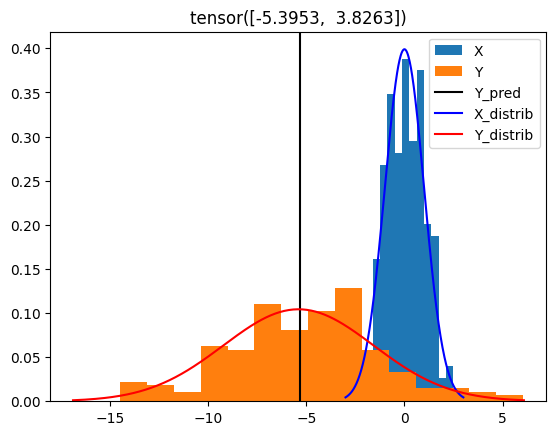

In [113]:
X = dataloader.dataset.X
Y = dataloader.dataset.Y
C = dataloader.dataset.C


Y_pred  = model(X, C)[0, :, 0].detach().numpy().mean()

plt.hist(X[0, :, 0],  bins=15, label = 'X', density = True)
plt.hist(Y[0, :, 0],  bins=15, label = 'Y', density = True)
plt.axvline(x = Y_pred, color = 'black', label = 'Y_pred')
plt.plot(np.linspace(-3, 3, 300), stats.norm.pdf(np.linspace(-3, 3, 300), loc=0, scale=1), label = 'X_distrib', color = 'blue')
plt.plot(np.linspace(-3*scales[0, 0] + locs[0, 0], 3*scales[0, 0] + locs[0, 0], 300), stats.norm.pdf(np.linspace(-3*scales[0, 0] + locs[0, 0], 3*scales[0, 0] + locs[0, 0], 300), loc=locs[0, 0], scale=scales[0, 0]), label = 'Y_distrib', color = 'red')
plt.title(C[0, 0, :])
plt.legend()

plt.show()

In [8]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for x_batch, c_batch, y_batch in dataloader:
        outputs = model(x_batch, c_batch)
        for result, y in zip(outputs, y_batch) :
            print(result, y)
        break

tensor([[0.2986, 0.2964],
        [0.3447, 0.3591],
        [0.3684, 0.3558],
        [0.3379, 0.3275],
        [0.3332, 0.3205],
        [0.2947, 0.2923],
        [0.3298, 0.3186],
        [0.3094, 0.3170],
        [0.3024, 0.3041],
        [0.3123, 0.3087],
        [0.3413, 0.3407],
        [0.3028, 0.2954],
        [0.2929, 0.2897],
        [0.3635, 0.3480],
        [0.2950, 0.2981],
        [0.3016, 0.3032],
        [0.3016, 0.2942],
        [0.3044, 0.2980],
        [0.3213, 0.3194],
        [0.3041, 0.2959],
        [0.2939, 0.2899],
        [0.3083, 0.3014],
        [0.3342, 0.3289],
        [0.3187, 0.3075],
        [0.3367, 0.3254],
        [0.3127, 0.3044],
        [0.3135, 0.3039],
        [0.3041, 0.3011],
        [0.3100, 0.3141],
        [0.2921, 0.2922],
        [0.3002, 0.3033],
        [0.3002, 0.3028],
        [0.3544, 0.3438],
        [0.2989, 0.2935],
        [0.3080, 0.3017],
        [0.2920, 0.2922],
        [0.3094, 0.3005],
        [0.3430, 0.3285],
        [0.3

### Makkuva

In [121]:
epochs = 50
train_freq_g = 2

# Initialize the model
# input_size = 2
# output_size = 1

# ICNNf = ICNNet(input_size = 2, layer_sizes = [input_size, 32, 32, 32,output_size], context_layer_sizes=[input_size,  32, 32, 32,output_size])
# ICNNg = ICNNet(input_size = 2, layer_sizes = [input_size,  32, 32, 32,output_size], context_layer_sizes=[input_size,  32, 32, 32,output_size])

# # ICNNf = ICNNet(input_size = 2, layer_sizes = [input_size, 2, 2, 2,2], context_layer_sizes=[2,2, 2, 2,2])
# # ICNNg = ICNNet(input_size = 2, layer_sizes = [output_size, 2, 2, 2,2], context_layer_sizes=[2,2, 2, 2,2]) 

# print(f'The model has {count_parameters(ICNNf)} parameters')
# # Define the loss function and the optimizer
# optimizer_f = optim.Adam(ICNNf.parameters())
# optimizer_g = optim.Adam(ICNNg.parameters())

for epoch in range(epochs):
    loss_g_big_mean = 0
    loss
    for i in range(train_freq_g) :
        loss_g_mean = 0
        for x, c, y in dataloader:
            # Optimizing ICNNg
            optimizer_f.zero_grad() # Zero the gradients
            optimizer_g.zero_grad() # Zero the gradients

            x.requires_grad_(True)
            y.requires_grad_(True)
            c.requires_grad_(True)

            output_g = ICNNg(y, c)
            grad_g = torch.autograd.grad(output_g, y, grad_outputs=torch.ones_like(output_g), create_graph=True)[0]

            loss_g = - torch.sum(torch.mul(y, grad_g), dim = -1, keepdim = True) + ICNNf(grad_g, c)
            loss_g = torch.mean(loss_g)

            loss_g.backward() # Backward pass
            optimizer_g.step() # Update the parameters

            loss_g_mean += loss_g.item()

            for layers_k in ICNNg.layers_z:
                for param in layers_k.parameters():
                    param.data.clamp_min_(0)
        print('loss_g ',i, " : ", loss_g_mean / len(dataloader))
                    
            # for name, parameter in ICNNg.named_parameters():
            #     if parameter.requires_grad and parameter.grad is not None:
            #         grad_norm = parameter.grad.norm().item()
            #         print(f"Gradient norm for {name}: {grad_norm}")

    for x, c, y in dataloader:
        optimizer_f.zero_grad() # Zero the gradients
        optimizer_g.zero_grad()

        x.requires_grad_(True)
        y.requires_grad_(True)
        c.requires_grad_(True)
    
        output_g = ICNNg(y, c)
        grad_g = torch.autograd.grad(outputs=output_g, inputs=y, grad_outputs=torch.ones_like(output_g), create_graph=True)[0]

        # print('ICNNf(grad_g, c)', ICNNf(grad_g, c))

        loss_f = ICNNf(x, c) - ICNNf(grad_g, c)
        loss_f =  torch.mean(loss_f)

        loss_f.backward() # Backward pass
        optimizer_f.step()
        
        for layers_k in ICNNf.layers_z:
                for param in layers_k.parameters():
                    param.data.clamp_min_(0)

        # for name, parameter in ICNNf.named_parameters():
        #     if parameter.requires_grad and parameter.grad is not None:
        #         grad_norm = parameter.grad.norm().item()
        #         print(f"Gradient norm for {name}: {grad_norm}")
        
    print(f"Epoch {epoch+1}/{epochs} loss_g: {loss_g.item()}, loss_f: {loss_f.item()}")

loss_g  0  :  -5.50699462890625
loss_g  1  :  -6.086042594909668
Epoch 1/50 loss_g: -4.914727210998535, loss_f: 0.04291711747646332
loss_g  0  :  -4.726384401321411
loss_g  1  :  -4.726384544372559
Epoch 2/50 loss_g: -4.36529016494751, loss_f: -0.16046132147312164
loss_g  0  :  -4.726384496688842
loss_g  1  :  -4.726384544372559
Epoch 3/50 loss_g: -5.674584865570068, loss_f: -0.2192181646823883
loss_g  0  :  -4.726384544372559
loss_g  1  :  -4.726384544372559
Epoch 4/50 loss_g: -5.104584693908691, loss_f: 0.13968142867088318
loss_g  0  :  -4.7263843536376955
loss_g  1  :  -4.72638463973999
Epoch 5/50 loss_g: -5.233531951904297, loss_f: 0.028038544580340385
loss_g  0  :  -4.7263847351074215
loss_g  1  :  -4.726384449005127
Epoch 6/50 loss_g: -5.242125988006592, loss_f: 0.05179976671934128
loss_g  0  :  -4.726384401321411
loss_g  1  :  -4.726384449005127
Epoch 7/50 loss_g: -3.7705492973327637, loss_f: 0.02824520319700241
loss_g  0  :  -4.72638430595398
loss_g  1  :  -4.726384544372559
Ep

In [21]:

torch.save(ICNNf.state_dict(), filename_pth_f)
torch.save(ICNNg.state_dict(), filename_pth_g)

In [129]:
filename_pth_f = 'ICNNf_64_4_uniform_1D.pth'
filename_pth_g = 'ICNNg_64_4_uniform_1D.pth'


ICNNf = ICNNet(input_size = 2, layer_sizes = [input_size,64,64,64,64,output_size], context_layer_sizes=[input_size,64,64,64,64,output_size])
ICNNf.load_state_dict(torch.load(filename_pth_f))

ICNNg = ICNNet(input_size = 2, layer_sizes = [input_size,64,64,64,64,output_size], context_layer_sizes=[input_size,64,64,64,64,output_size])
ICNNg.load_state_dict(torch.load(filename_pth_g))

TypeError: super(type, obj): obj must be an instance or subtype of type

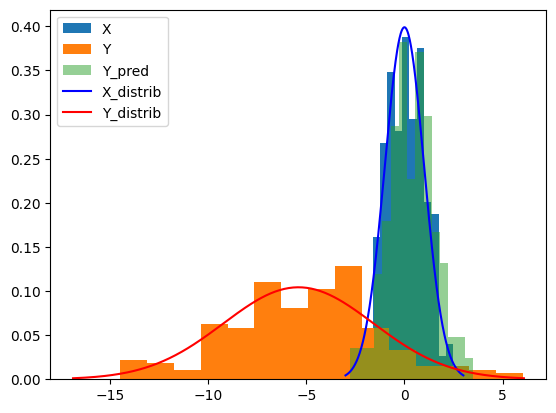

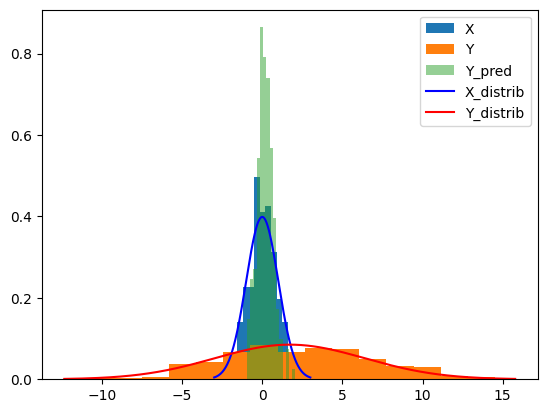

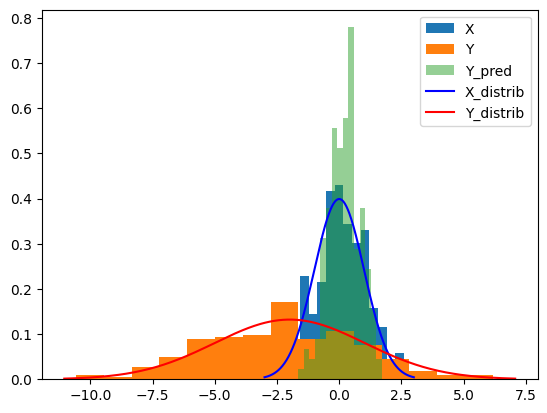

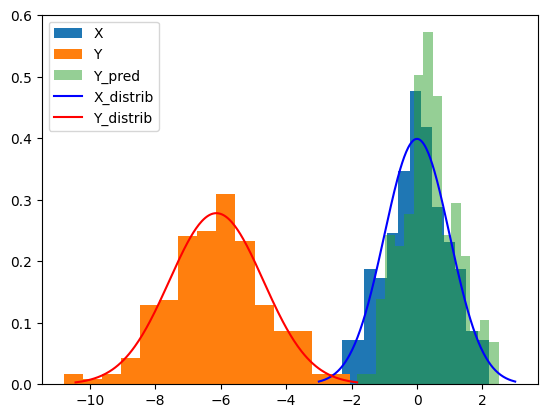

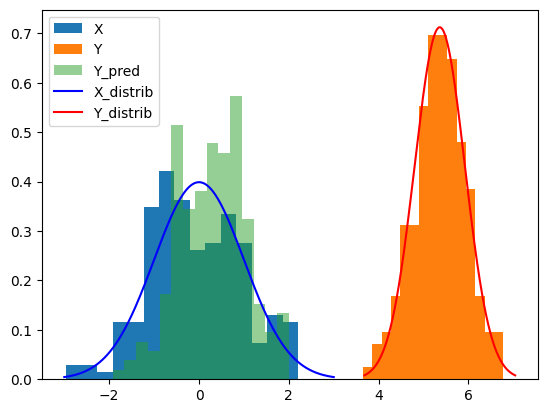

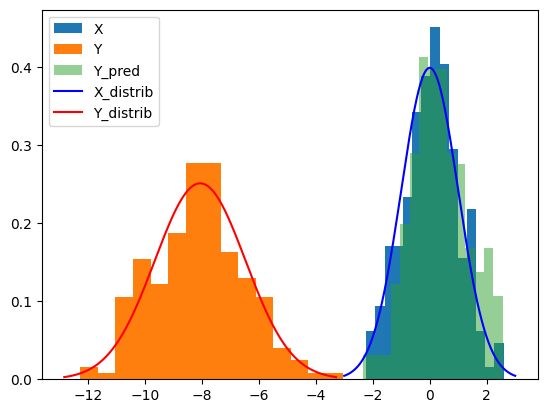

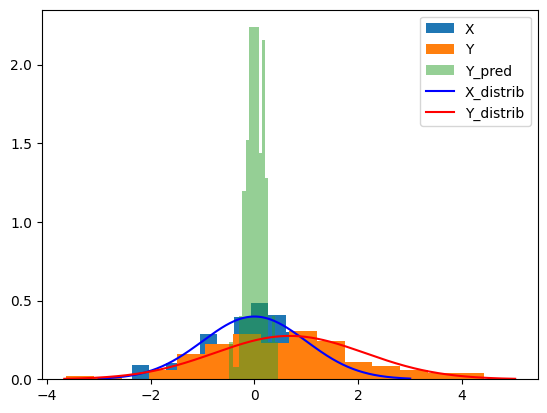

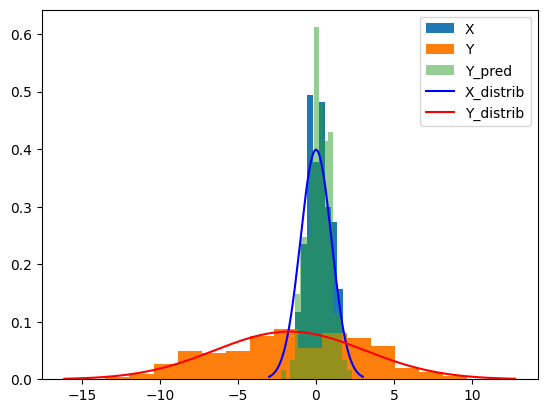

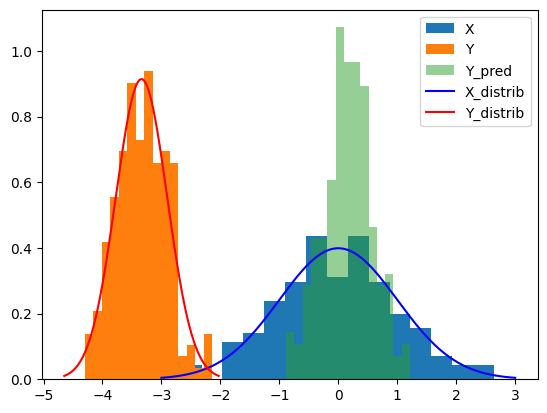

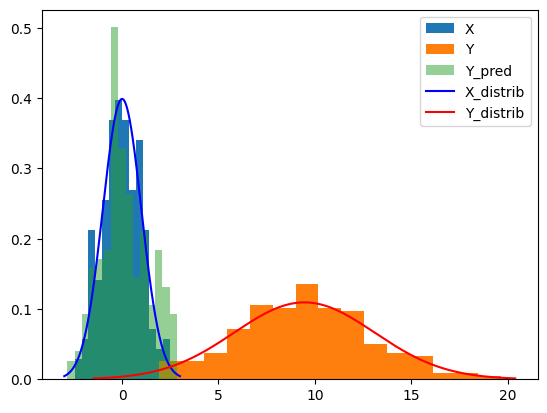

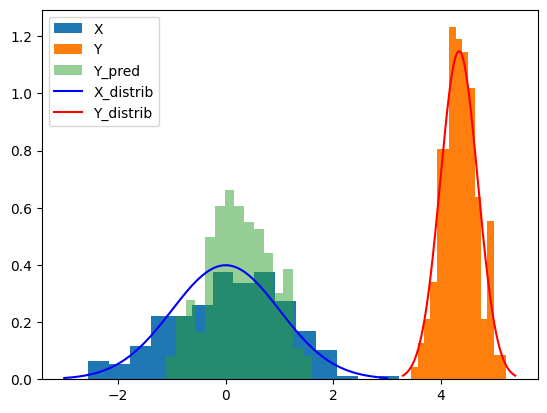

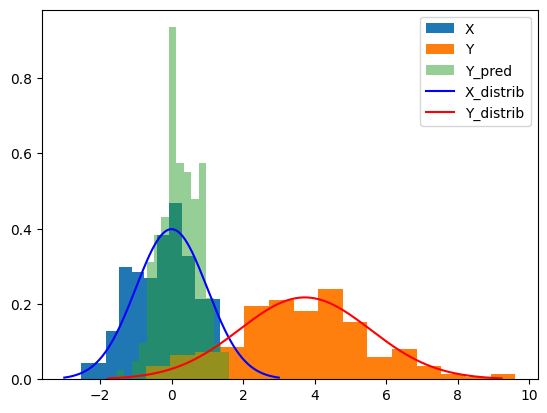

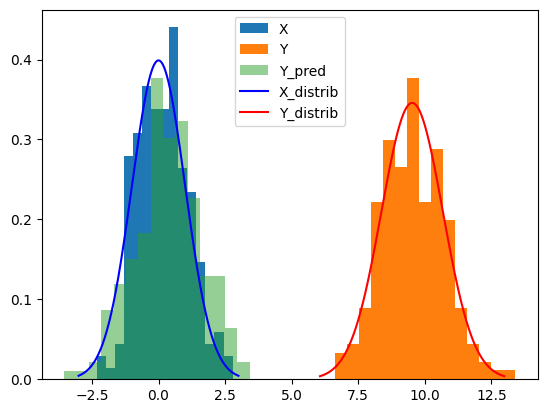

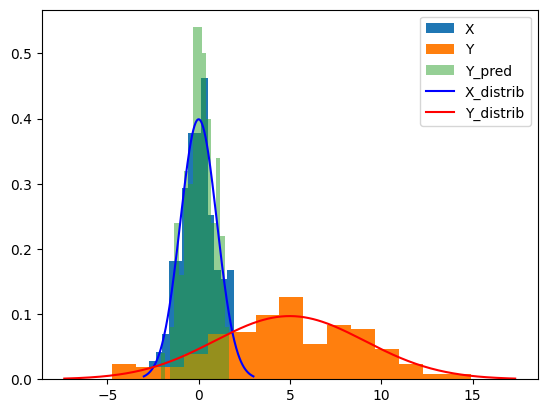

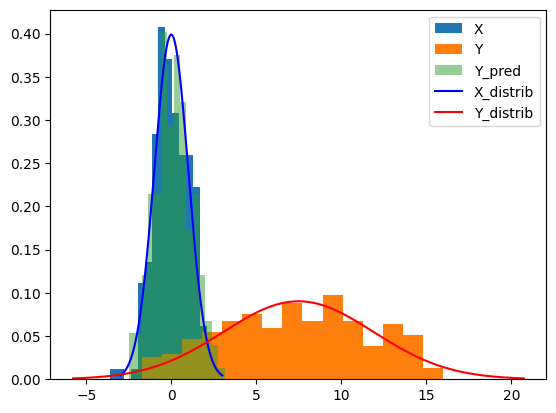

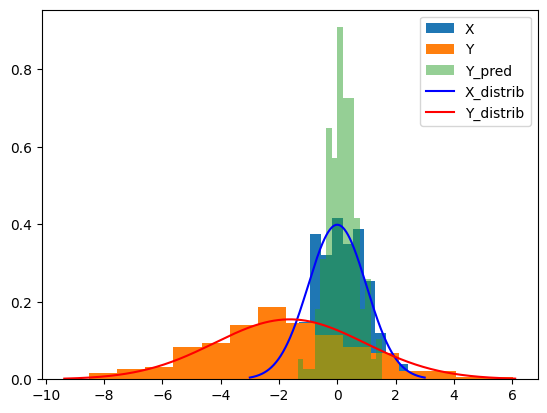

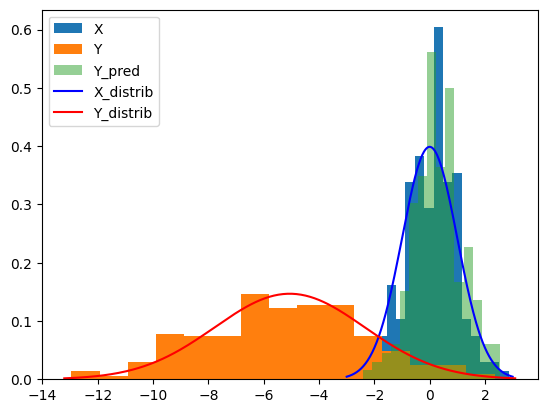

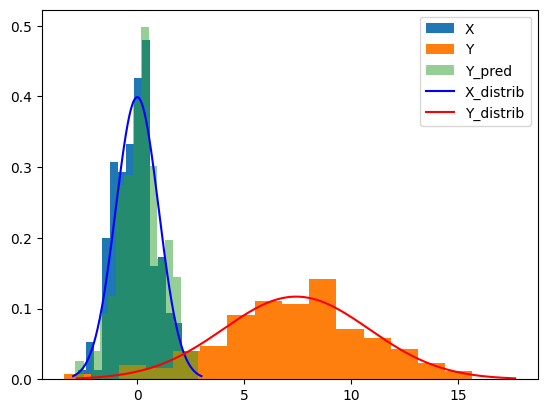

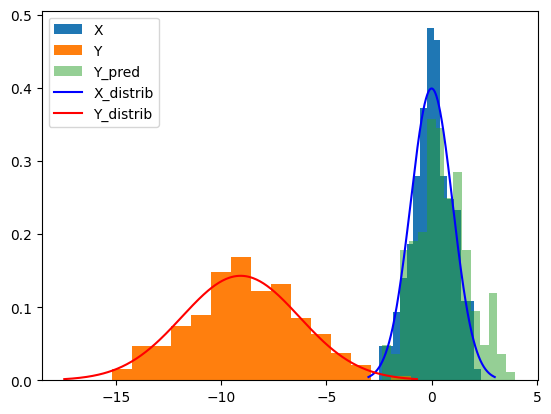

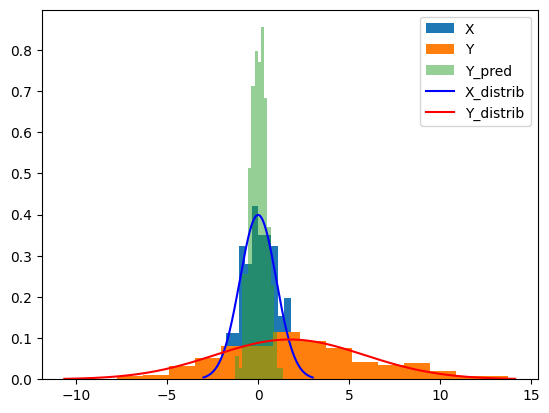

In [120]:
for test in range(20):
    X = dataloader.dataset.X
    Y = dataloader.dataset.Y
    C = dataloader.dataset.C


    Y_pred = ICNNf(X, C)[test, :, 0].detach().numpy()
    X_pred = ICNNg(Y, C)[test, :, 0].detach().numpy()


    plt.hist(X[test, :, 0],  bins=15, label = 'X', density = True)
    plt.hist(Y[test, :, 0],  bins=15, label = 'Y', density = True)
    plt.hist(Y_pred,  bins=15, label = 'Y_pred', density = True, alpha = 0.5)
    # plt.hist(X_pred,  bins=15, label = 'X_pred', density = True, alpha = 0.5)
    plt.plot(np.linspace(-3, 3, 300), stats.norm.pdf(np.linspace(-3, 3, 300), loc=0, scale=1), label = 'X_distrib', color = 'blue')
    plt.plot(np.linspace(-3*scales[test, 0] + locs[test, 0], 3*scales[test, 0] + locs[test, 0], 300), stats.norm.pdf(np.linspace(-3*scales[test, 0] + locs[test, 0], 3*scales[test, 0] + locs[test, 0], 300), loc=locs[test, 0], scale=scales[test, 0]), label = 'Y_distrib', color = 'red')

    plt.legend()
    plt.show()

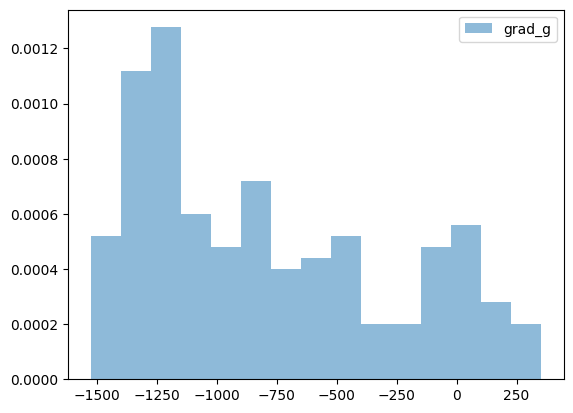

In [66]:
#Calcul de la dérivée du PICNN

test =  25
x_i = X[test, :, :]
c_i = C[test, :, :]


x_i.requires_grad_(True)
#c_i.requires_grad_(True)    

output_g = ICNNg(x_i, c_i)
grad_g = torch.autograd.grad(outputs=output_g, inputs=y_i, grad_outputs=torch.ones_like(output_g), create_graph=True)[0]


#plt.hist(X[test, :, 0],  bins=15, label = 'X', density = True)
#plt.hist(Y[test, :, 0],  bins=15, label = 'Y', density = True)
plt.hist(grad_g[:, 0].detach().numpy(),  bins=15, label = 'grad_g', density = True, alpha = 0.5)
plt.legend()

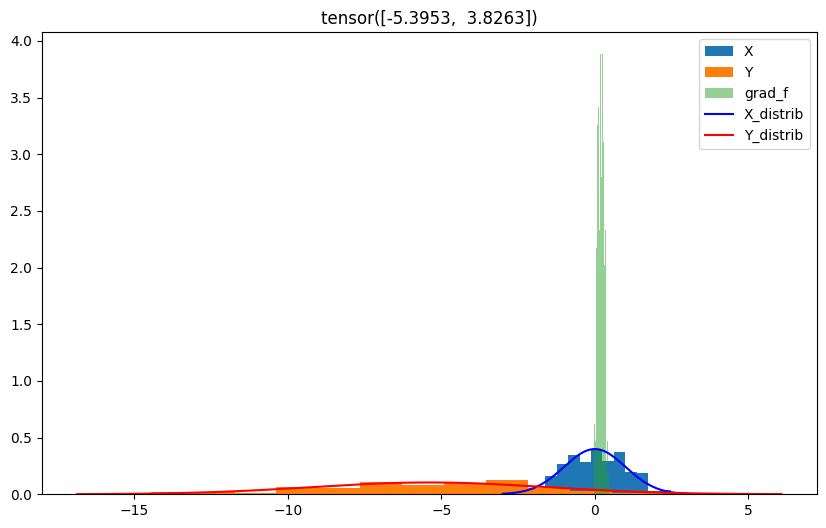

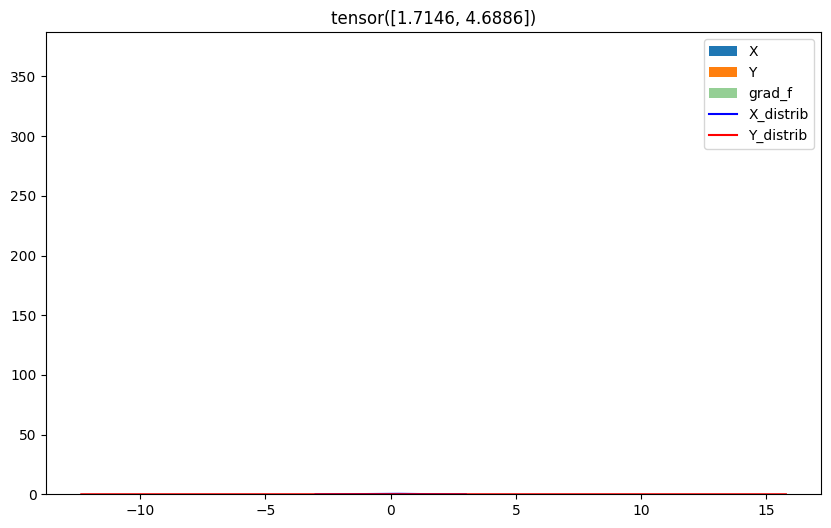

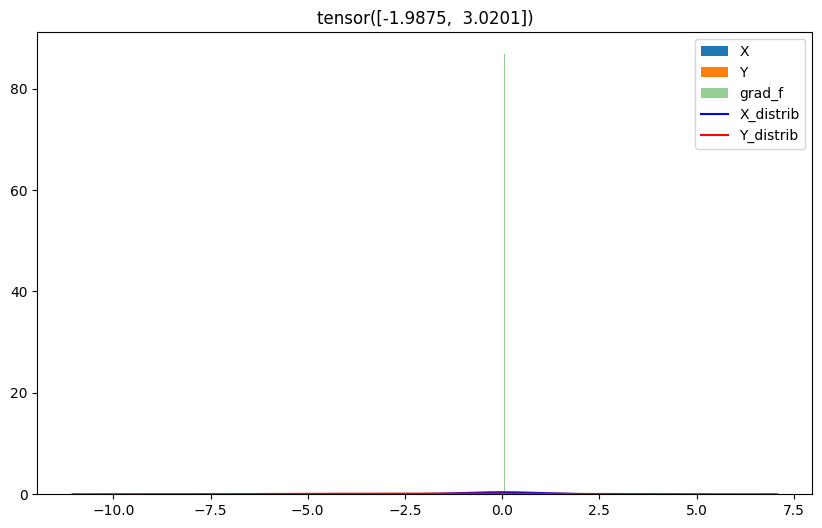

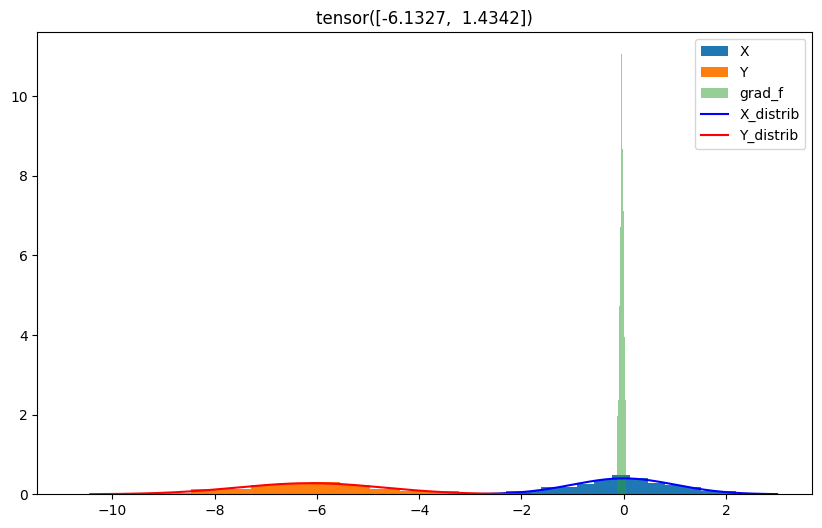

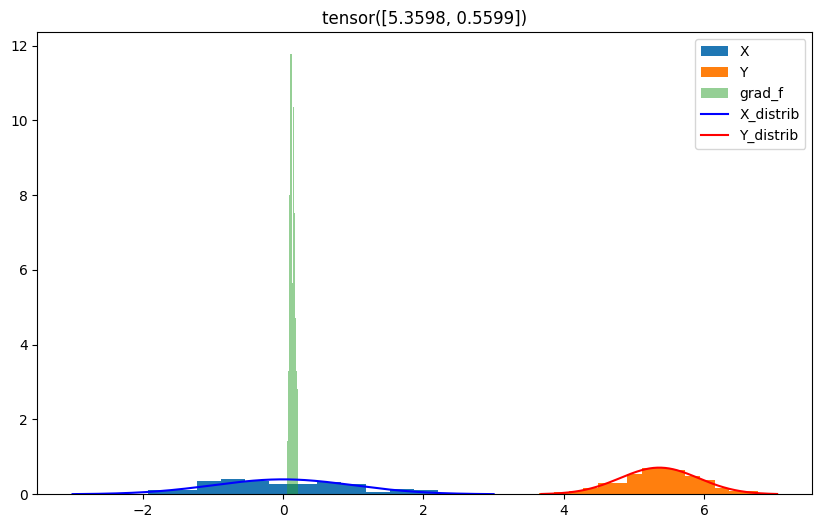

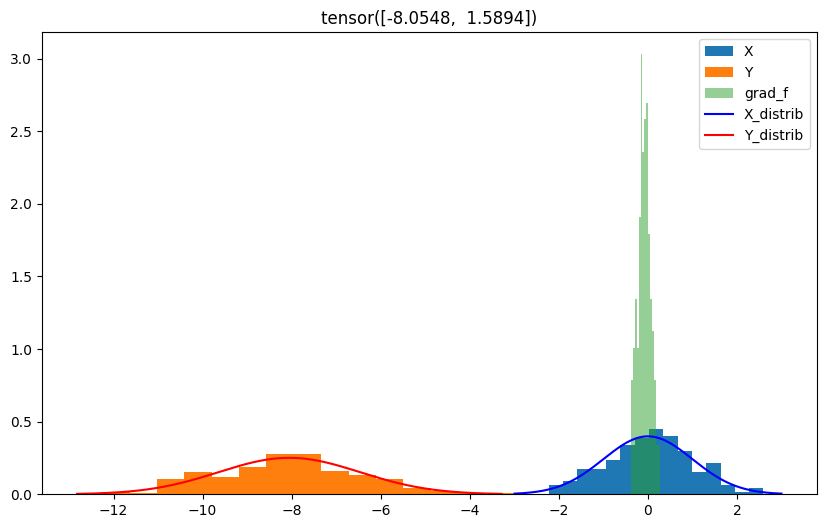

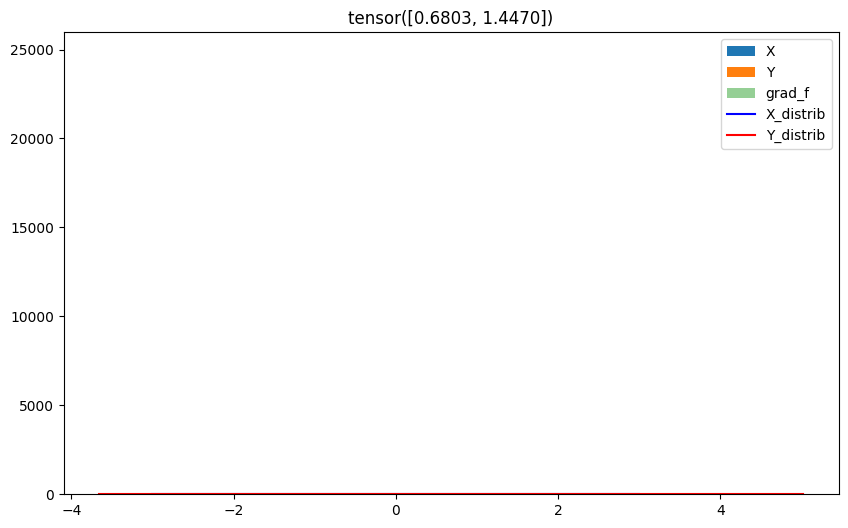

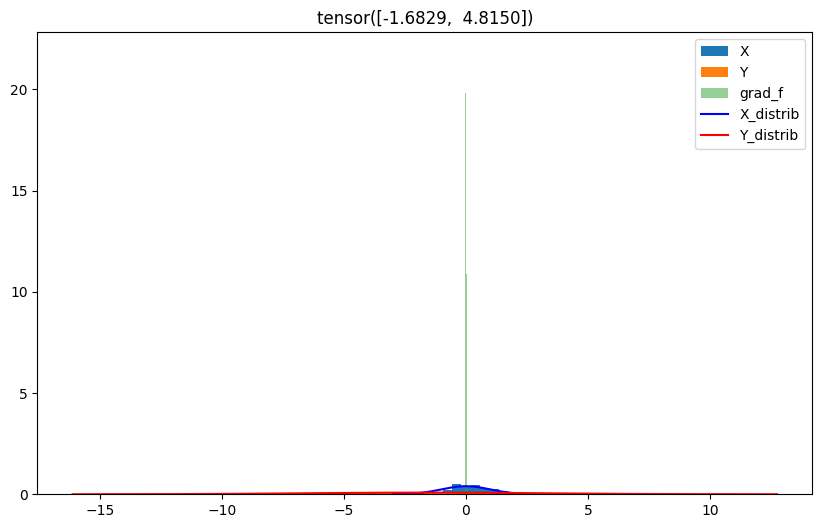

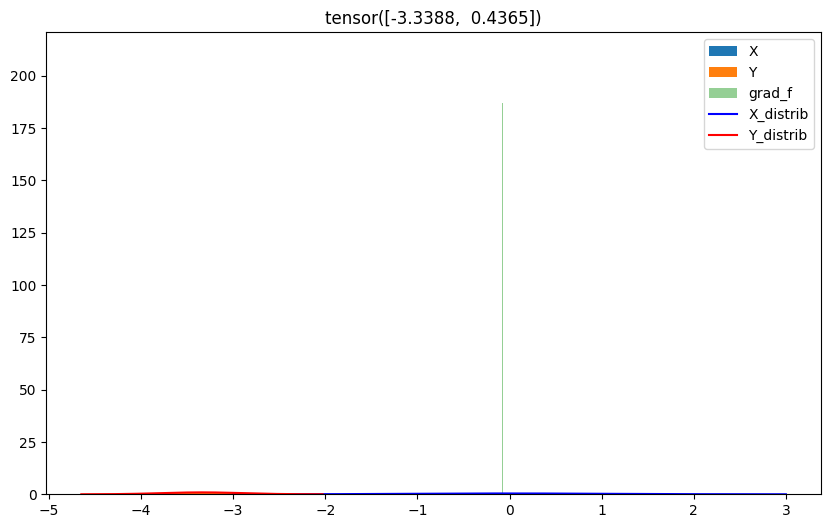

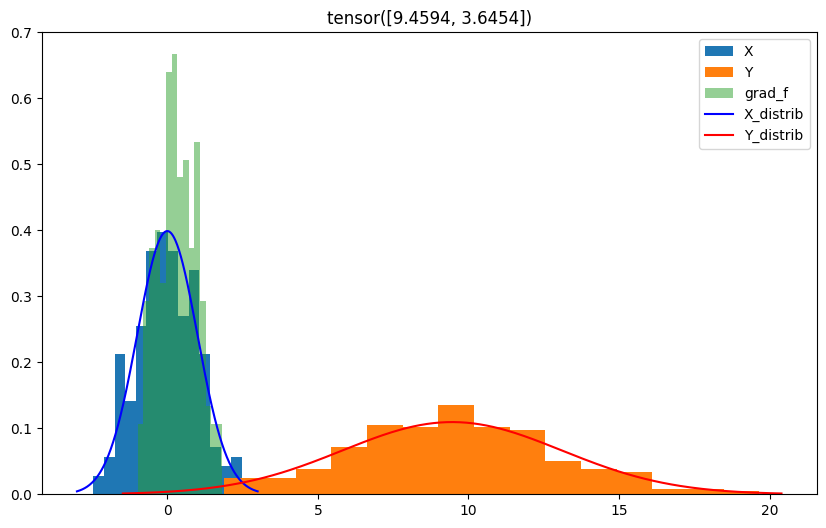

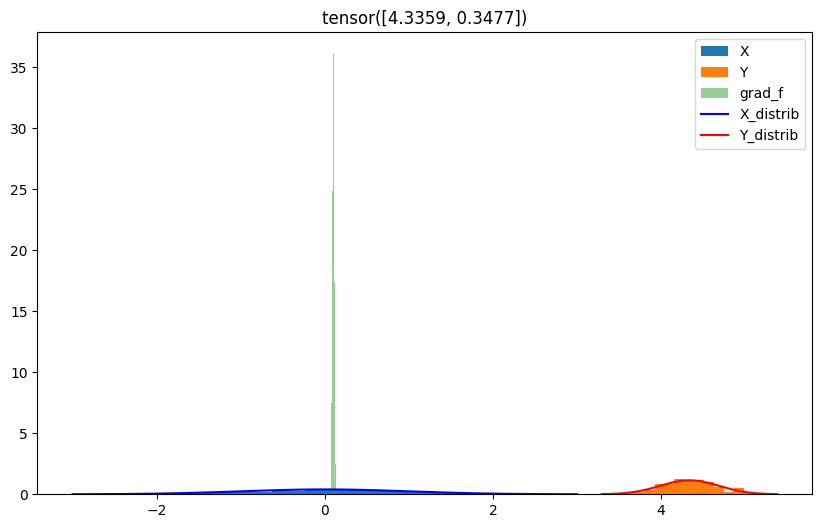

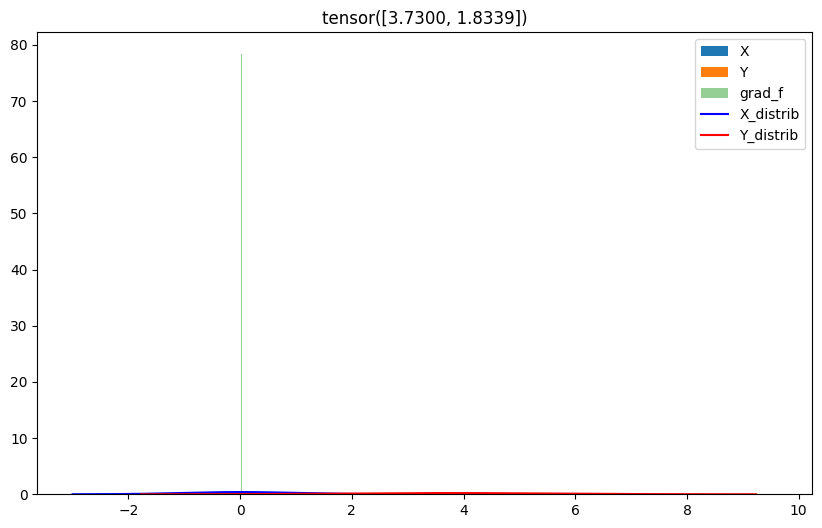

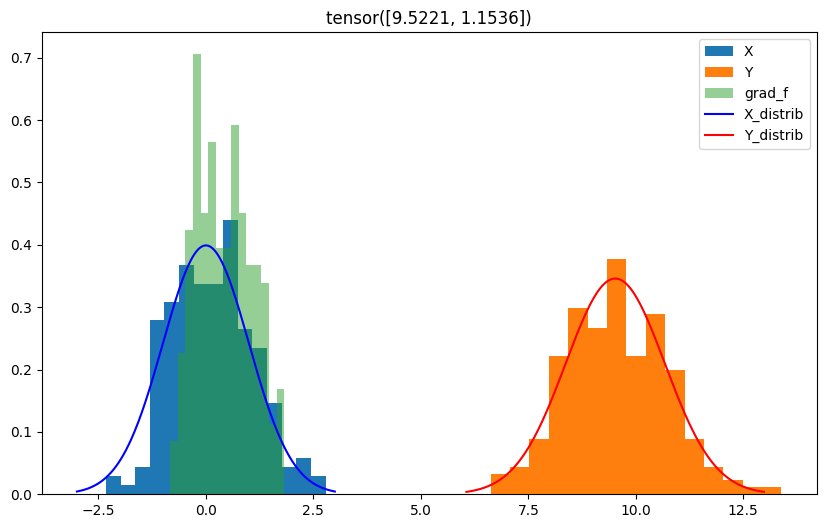

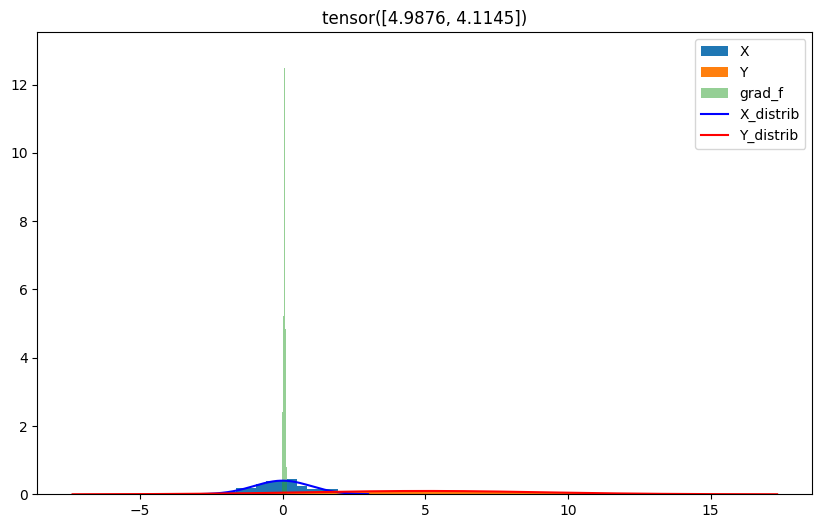

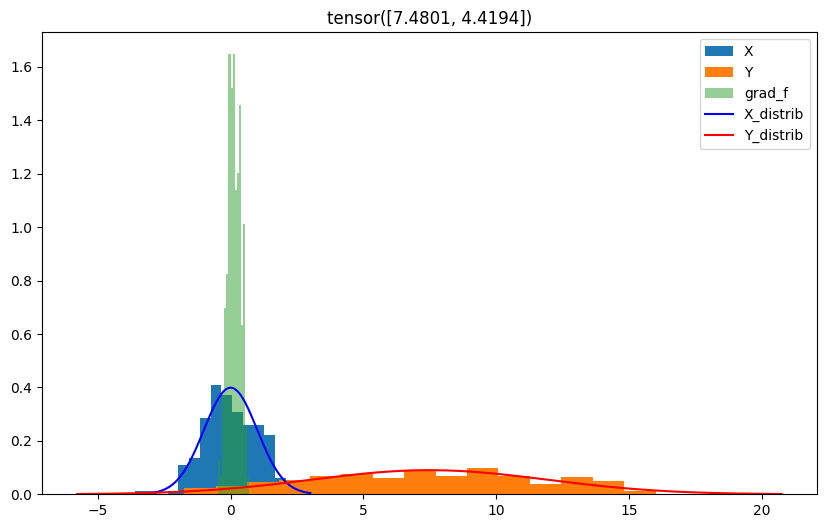

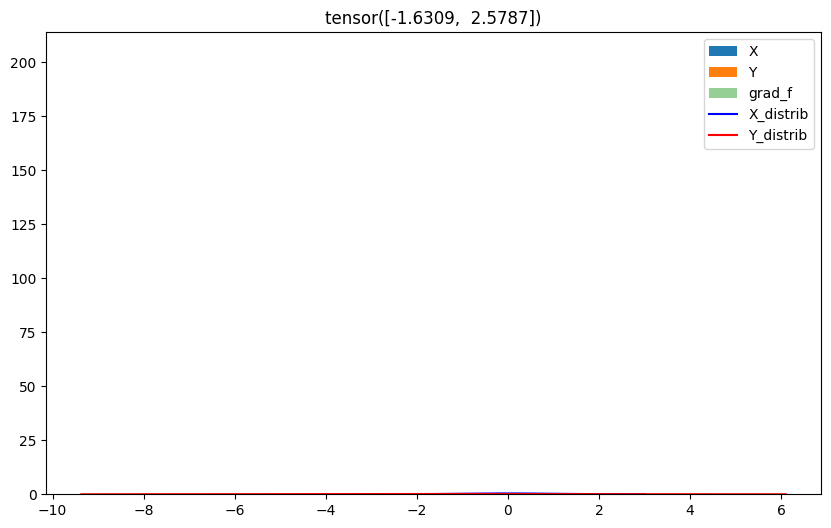

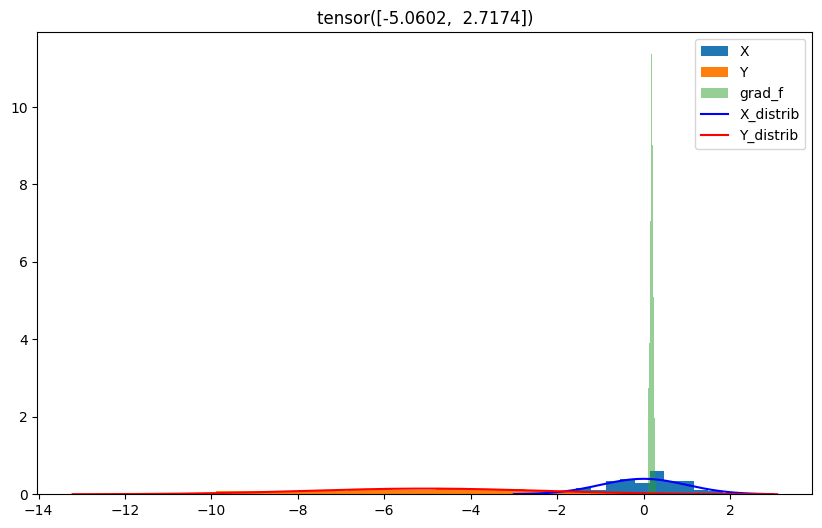

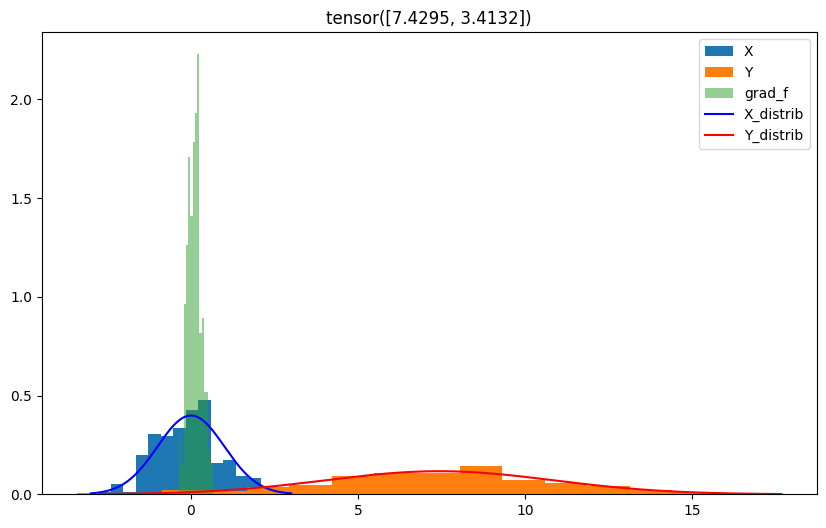

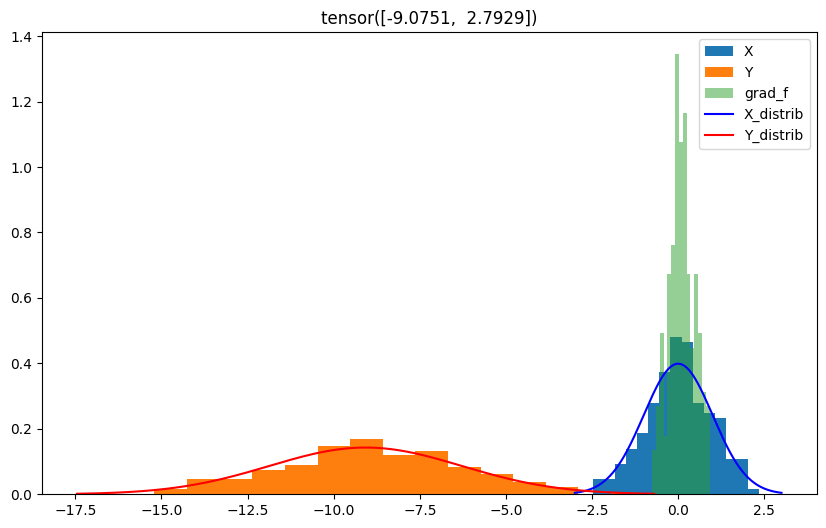

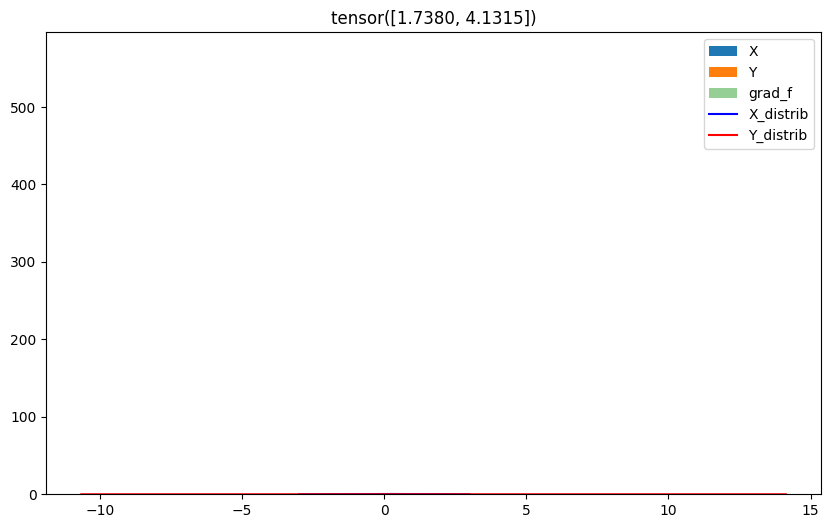

In [125]:
#Calcul de la dérivée du PICNN

for test in range(20):
    x_i = X[test, :, :]
    y_i = Y[test, :, :]
    c_i = C[test, :, :]


    y_i.requires_grad_(True)
    x_i.requires_grad_(True)
    #c_i.requires_grad_(True)    

    output_g = ICNNg(x_i, c_i)


    grad_f = torch.autograd.grad(outputs=output_g, inputs=x_i, grad_outputs=torch.ones_like(output_f), create_graph=True)[0]

    plt.figure(figsize=(10, 6))  # Create a new figure for each test with a larger size


    plt.hist(X[test, :, 0],  bins=15, label = 'X', density = True)
    plt.hist(Y[test, :, 0],  bins=15, label = 'Y', density = True)
    plt.hist(grad_f[:, 0].detach().numpy(),  bins=15, label = 'grad_f', density = True, alpha = 0.5)
    # plt.hist(X_pred,  bins=15, label = 'X_pred', density = True, alpha = 0.5)
    plt.plot(np.linspace(-3, 3, 300), stats.norm.pdf(np.linspace(-3, 3, 300), loc=0, scale=1), label = 'X_distrib', color = 'blue')
    plt.plot(np.linspace(-3*scales[test, 0] + locs[test, 0], 3*scales[test, 0] + locs[test, 0], 300), stats.norm.pdf(np.linspace(-3*scales[test, 0] + locs[test, 0], 3*scales[test, 0] + locs[test, 0], 300), loc=locs[test, 0], scale=scales[test, 0]), label = 'Y_distrib', color = 'red')
    plt.title(C[test, 0, :])

    plt.legend()

    plt.show()